<a href="https://colab.research.google.com/github/Yahya-Abbas/Practical-Machine-Deep-Learning-Course/blob/main/Lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table align="center">
  <td align="center"><a target="_blank" href="https://colab.research.google.com/github/KhaledElTahan/DeepLearning/blob/master/Labs/lab3/Lab3.ipynb">
        <img src="http://introtodeeplearning.com/images/colab/colab.png?v2.0"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
</table>

# Lab3: Convolutional Neural Network Use Cases

![Simple CNN](https://github.com/KhaledElTahan/DeepLearning/blob/master/Labs/lab3/Cover.png?raw=1)

## 3.1 Problem Statement

In this lab you will build several CNN models that check if a person is happy or not. You will use custom made CNN, and CNN use cases either pretrained or not, also you will apply layers freezing on pretrained CNNs and study all those modifications effect on the accuracy.

**IMPORTANT NOTE:** You have to change runtime type on Google Colab to GPU since this lab requires much computation resources and it will run very slowly on CPU (Default runtime type)

## 3.2 Problem Details

### 3.2.1 Packages & Utility Methods

In [183]:
import tensorflow as tf
import numpy as np

from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.utils import plot_model
from tensorflow.keras import applications
import tensorflow.keras.backend as K
K.set_image_data_format('channels_last')

from IPython.display import SVG
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pydot
import h5py
import random
import requests
import cv2

%matplotlib inline

In [103]:
def download_file(file_url):
    file_r = requests.get(file_url, allow_redirects=True)
    open(file_url.rsplit('/', 1)[1], 'wb').write(file_r.content)

### 3.2.2 Dataset Loading

#### Define method to download & load dataset

In [104]:
def load_dataset():
    download_file("https://raw.githubusercontent.com/KhaledElTahan/DeepLearning/master/Labs/lab3/lab3_train.h5")
    download_file("https://raw.githubusercontent.com/KhaledElTahan/DeepLearning/master/Labs/lab3/lab3_test.h5")

    path_to_train = "lab3_train.h5"
    path_to_test = "lab3_test.h5"

    train_dataset = h5py.File(path_to_train, "r")
    train_x = np.array(train_dataset['train_set_x'][:])
    train_y = np.array(train_dataset['train_set_y'][:])

    test_dataset = h5py.File(path_to_test, "r")
    test_x = np.array(test_dataset['test_set_x'][:])
    test_y = np.array(test_dataset['test_set_y'][:])

    # reshape y from (samples, ) to (1, samples)
    train_y = train_y.reshape((1, train_x.shape[0]))
    test_y = test_y.reshape((1, test_x.shape[0]))

    # transpose y
    train_y = train_y.T
    test_y = test_y.T

    f=lambda x:cv2.resize(x,(75,75))
    train=np.array(list(map(f,train_x)))

    return train_x, train_y, test_x, test_y

#### Define method to make simple preprocessing on the dataset

In [105]:
def preprocess_data():
    train_x, train_y, test_x, test_y = load_dataset()

    # Normalize image vectors
    train_x = train_x/255.
    test_x = test_x/255.

    print ("number of training examples = " + str(train_x.shape[0]))
    print ("number of test examples = " + str(test_x.shape[0]))

    print ("X_train shape: " + str(train_x.shape))
    print ("Y_train shape: " + str(train_y.shape))
    print ("X_test shape: " + str(test_x.shape))
    print ("Y_test shape: " + str(test_y.shape))

    return train_x, train_y, test_x, test_y

#### Get the preprocessed Data

In [155]:
train_x, train_y, test_x, test_y = preprocess_data()


# Resize the images to have the minimum required size for Inception networks
f = lambda x:cv2.resize(x,(75,75))

train_x_inception = np.array(list(map(f,train_x)))
test_x_inception = np.array(list(map(f,test_x)))

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


### 3.2.3 Dataset Visualization

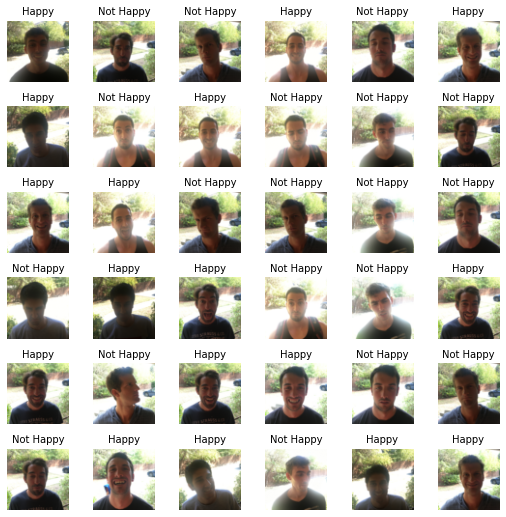

In [156]:
W_grid = 6
L_grid = 6

fig, axes = plt.subplots(L_grid, W_grid, figsize = (9,9))

axes = axes.ravel() # flaten the L_grid x W_grid matrix into L_grid * W_grid array

n_training = len(train_x) # get the length of the training dataset

for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 

    index = np.random.randint(0, n_training)
    axes[i].imshow(train_x[index])

    if train_y[index] == 1:
        axes[i].set_title("Happy", fontsize = 10)
    else:
        axes[i].set_title("Not Happy", fontsize = 10)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

### 3.2.4 Plot Utility Methods

The following code is used to plot accuracy and loss histories for each model experiment.

In [157]:
def plot(training_results, validation_results, results_type, model_name):
    fig = plt.figure(figsize=[8, 6])

    plt.plot(training_results, 'r', linewidth=3.0)
    plt.plot(validation_results, 'b', linewidth=3.0)
    plt.legend(['Training ' + results_type, 'Validation ' + results_type], fontsize=18)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel(results_type, fontsize=16)
    plt.title(results_type + ' of ' + model_name, fontsize=16)


def plot_accuracy(history, model_name):
    plot(history.history['accuracy'], history.history['val_accuracy'], 'Accuracy', model_name)
    

def plot_loss(history, model_name):
    plot(history.history['loss'], history.history['val_loss'], 'Loss', model_name)

### 3.2.5 Custom CNN Model

**TODO**: Build a custom CNN model to solve the problem.

Model guidelines (You need to follow them):

1. [Input](https://keras.io/api/layers/core_layers/input/)Layer.

2. [ZeroPadding2D](https://keras.io/api/layers/reshaping_layers/zero_padding2d/) Layer.

3. [Conv2D](https://keras.io/api/layers/convolution_layers/convolution2d/) Layer.

4. [BatchNormalization](https://keras.io/api/layers/normalization_layers/batch_normalization/) Layer. Read [this article](https://kharshit.github.io/blog/2018/12/28/why-batch-normalization) for more about Batchnormalization.
5. Relu [Activation](https://keras.io/api/layers/core_layers/activation/).
6. [MaxPooling2D](https://keras.io/api/layers/pooling_layers/max_pooling2d/) Layer.
7. [Flatten](https://keras.io/api/layers/reshaping_layers/flatten/) Layer.
8. [Dense](https://keras.io/api/layers/core_layers/dense/) with Sigmoid Layer (one perceptrion).

**Note**: If you made the required model, you can make other custom CNN models if you wish to further improve the accuracy, but in other code cells however.

In [113]:
def CustomCNN(input_shape):
    """
    Implementation of the Custom CNN.
    Args:
        input_shape () shape of the images of the dataset
    Returns:
        model (Keras.Model): CNN Custom Model
        model_name (Str): The name of the model
    """
    
    ### START CODE HERE ###
    X_input = Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((3, 3))(X_input)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv')(X)
    X = BatchNormalization(axis=3, name='bn0')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D(pool_size=(2,2), name='maxpool')(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED (Dense)
    X = Flatten()(X)
    Y = Dense(units=1, activation='sigmoid', kernel_regularizer='L2', name='dense')(X)
    
    # Create model. This creates your tensorflow.keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs=X_input, outputs=Y)
    ### END CODE HERE ###
    
    return model, "Custom CNN"

### 3.2.6 CNN Use Case No.1: VGG

![VGG Architecture](https://github.com/KhaledElTahan/DeepLearning/blob/master/Labs/lab3/vgg.png?raw=1)

**Note**: this is a show case to help you do the same with other use cases.

**TODO**: Try different variations for VGG:

1. [VGG16](https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG16)
2. [VGG19](https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG19)

**Note**: You will need to experiment all of them both pretrained (both with or without layers freezing) and also untrained.

In [114]:
def VGG(pretrained = True, input_shape = (64, 64, 3), model_name = "VGG16"):
    """
    Returns VGG Keras Model
    Args:
        pretrained (Bool): Whether get a pretrained model or not
        input_shape (Tuple): To create the input layer, should match the image resolution
        model_name (str): String to capture the model name
    Examples:
        VGG(True) -> Model, "Pretrained VGG16"
    """
    if(pretrained):
        model_name1 = "Pretrained " + model_name
        
        if(model_name == "VGG16"):
            base_model = applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=input_shape, pooling='none')
        else:
            base_model = applications.vgg19.VGG19(weights='imagenet', include_top=False, input_shape=input_shape, pooling='none')
    
    else:
        model_name1 = "Untrained " + model_name
        
        if(model_name=="VGG16"):
            base_model = applications.vgg16.VGG16(weights=None, include_top=False, input_shape=input_shape, pooling='none')
        else:
            base_model = applications.vgg19.VGG19(weights=None, include_top=False, input_shape=input_shape, pooling='none')
    
    return base_model, model_name1

### 3.2.7 CNN Use Case No.2: ResNet

![VGG vs ResNet](https://github.com/KhaledElTahan/DeepLearning/blob/master/Labs/lab3/VGG_vs_ResNet.png?raw=1)

**TODO**: Follow the same style for the above mentioned VGG and experiment the following ResNets:

1. [ResNet50](https://www.tensorflow.org/api_docs/python/tf/keras/applications/ResNet50)
2. [ResNet50V2](https://www.tensorflow.org/api_docs/python/tf/keras/applications/ResNet50V2)
3. [ResNet101](https://www.tensorflow.org/api_docs/python/tf/keras/applications/ResNet101)
4. [ResNet101v2](https://www.tensorflow.org/api_docs/python/tf/keras/applications/ResNet101V2)

**Note 1**: You will need to experiment all of them both pretrained (both with or without layers freezing) and also untrained.

**Note 2**: For very deep networks like ResNet101, the size of the input might get reduced too much and an error might be produced, you shall fix this issue by either resizing input image (preferred) or by adding padding.

In [115]:
def ResNet(pretrained = True, input_shape = (64, 64, 3), model_name = "ResNet50"):
    """
    Returns ResNet Keras Model
    Args:
        pretrained (Bool): Whether get a pretrained model or not
        input_shape (Tuple): To create the input layer, should match the image resolution
        model_name (str): String to capture the model name
    Examples:
        ResNet(True) -> Model, "Pretrained ResNet50"
    """
    if(pretrained):
        model_name1 = "Pretrained " + model_name
        
        if(model_name == "ResNet50"):
            base_model = applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape, pooling='none')
        elif(model_name == "ResNet50V2"):
            base_model = applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape, pooling='none')
        elif(model_name == "ResNet101"):
            base_model = applications.ResNet101(weights='imagenet', include_top=False, input_shape=input_shape, pooling='none')        
        else:
            base_model = applications.ResNet101V2(weights='imagenet', include_top=False, input_shape=input_shape, pooling='none')
    
    else:
        model_name1 = "Untrained " + model_name
        
        if(model_name == "ResNet50"):
            base_model = applications.ResNet50(weights=None, include_top=False, input_shape=input_shape, pooling='none')
        elif(model_name == "ResNet50V2"):
            base_model = applications.ResNet50V2(weights=None, include_top=False, input_shape=input_shape, pooling='none')
        elif(model_name == "ResNet101"):
            base_model = applications.ResNet101(weights=None, include_top=False, input_shape=input_shape, pooling='none')        
        else:
            base_model = applications.ResNet101V2(weights=None, include_top=False, input_shape=input_shape, pooling='none')

    return base_model, model_name1

### 3.2.8 CNN Use Case No.3: Inception

1.   [InceptionResNetV2](https://www.tensorflow.org/api_docs/python/tf/keras/applications/InceptionResNetV2)
2.   [InceptionV3](https://www.tensorflow.org/api_docs/python/tf/keras/applications/InceptionV3)



**TODO**: Select one application other than VGG or ResNet from [here](https://www.tensorflow.org/api_docs/python/tf/keras/applications) and implement it the same way you did with VGG & ResNet.

**Note**: You will need to experiment it in both pretrained (both with or without layers freezing) and also untrained.

In [158]:
def CNN_App(pretrained = True, input_shape = (75, 75, 3), model_name="InceptionResNetV2"):
    """
    Returns A Custom CNN Application Keras Model
    Args:
        pretrained (Bool): Whether get a pretrained model or not
        input_shape (Tuple): To create the input layer, should match the image resolution
        model_name (str): String to capture the model name
    Examples:
        CNN_App(True, (64, 64, 3), "Xception") -> Model, "Pretrained Xception"
    """
    if(pretrained):
        model_name1 = "Pretrained " + model_name
        if(model_name == "InceptionResNetV2"):
            base_model = applications.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=input_shape, pooling='none')
        else:
            base_model = applications.InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape, pooling='none')
    
    else:
        model_name1 = "Untrained " + model_name
        
        if(model_name == "InceptionResNetV2"):
            base_model = applications.InceptionResNetV2(weights=None, include_top=False, input_shape=input_shape, pooling='none')
        else:
            base_model = applications.InceptionV3(weights=None, include_top=False, input_shape=input_shape, pooling='none')

    return base_model, model_name1

### 3.2.9 Layers Freezing

The following utility method is used for layers freezing.

**TODO**: Experiment all the pretrained models with layers freezing using different number of frozen layers. 

**NOTE**: You will not change this method at all, the experimenting will take place in the test cases section below.

In [59]:
def freeze(model, number_of_frozen_layers):
    layers = model.layers

    layers = layers[:number_of_frozen_layers]

    for layer in layers:
        layer.trainable = False

    return model

### 3.2.10 Make your models

Use the following utility method to make the model you desire.

In [159]:
def make_model(pretrained=True, freeze_layers=False, number_of_frozen_layers=0, model_selection="VGG",
               model_name="VGG16"):
    """
    Use this method to create models
    Args:
      pretrained (Bool): Whether make the model pretrained or not, doesn't apply to custom CNN.
      freeze_layers (Bool): Whether apply layers freezing on pretrained networks or not.
      number_of_frozen_layers (int): Number of frozen layers.
      model_selection (Str): Must be exactly "Custom", or "VGG", or "ResNet" or anything else for CNN_App

      model_name (Str): Must be exactly "VGG16", "VGG19", "ResNet50", "ResNet50V2", "ResNet101", "ResNet101V2",
                        "InceptionResNetV2", or "InceptionV3"
    """

    input_shape = (64, 64, 3)

    if model_selection == "Custom":
        model, model_name = CustomCNN(input_shape)
    elif model_selection == "VGG":
        model, model_name = VGG(pretrained, input_shape, model_name)
    elif model_selection == "ResNet":
        model, model_name = ResNet(pretrained, input_shape, model_name)
    else:
        model, model_name = CNN_App(pretrained, (75, 75, 3), model_name)

    if model_selection != "Custom":
        if freeze_layers:
            model = freeze(model, number_of_frozen_layers)
            model_name = model_name + " with " + str(number_of_frozen_layers) + " Frozen Layers"

        ## Add classification head for non custom models
        y = model.output
        y = Flatten()(y)
        y = Dense(256, activation='relu')(y)
        y = Dense(1, activation='sigmoid', name='fc')(y)

        model = Model(inputs=model.input, outputs=y)

    return model, model_name

### 3.2.11 Testing model utility method

This is a generic method that will be used to test all the implemented models, a modular design allows you to experiment more clearly.

**TODO**:

1. Try different [optimizers](https://keras.io/api/optimizers/) and report their affect on the **results** and plots.
2. For each optimizer, try different learning rates and other hyperparameters (If applicable), and report the difference on the **results** and plots.
3. Try different [loss functions](https://keras.io/api/losses/), and report their affect on **accuracy** and plots. 

**Note**: You don't need to try different optimizers, rates & losses on all models, just find the best model with the current optimizers, rates & losses then try your experiments (changing optimizers, rates & losses) only on this model.

In [216]:
def test_model(model, model_name, epochs=10, print_summary=True, plot_results=True):
    '''TODO: Experiment with different optimizers, learning rates, and losses'''

    sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
    rmsprop = RMSprop(learning_rate=0.0001, momentum=0.9)
    adam = Adam(learning_rate=0.0001)
    adadelta = Adadelta(learning_rate=0.0001)
    adagrad = Adagrad(learning_rate=0.0001)
    adamax = Adamax(learning_rate=0.0001)
    nadam = Nadam(learning_rate=0.0001)
    ftrl = Ftrl(learning_rate=0.0001)

    model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

    if (print_summary):
        model.summary()

    if(("InceptionResNetV2" in model_name) or ("InceptionV3" in model_name)):
        hist = model.fit(train_x_inception, train_y, validation_data = (test_x_inception, test_y), verbose=1, epochs=epochs, batch_size=32)
        preds = model.evaluate(test_x_inception, test_y, batch_size=32, verbose=1, sample_weight=None)
    else:
        hist = model.fit(train_x, train_y, validation_data = (test_x, test_y), verbose=1, epochs=epochs, batch_size=32)
        preds = model.evaluate(test_x, test_y, batch_size=32, verbose=1, sample_weight=None)

    print ("Validation Loss = " + str(preds[0]))
    print ("Validation Accuracy = " + str(preds[1]))

    if(plot_results):
        plot_loss(hist, model_name)
        plot_accuracy(hist, model_name)

### 3.2.12 Create your model test cases.

**TODO**: Fill here all the test cases methods that you want to apply.

Add methods (Untrained, pretrained & pretrained with freezing) for:
1. ResNet 
2. CNN App

**NOTE**: Those test cases, don't change use case types (i.e. you will need to change the VGG in VGG() method to VGG19 and re test again for example) and doesn't change the loss function nor the optimizer type.


In [161]:
def test_custom_CNN(epochs=20, print_summary=True, plot_results=True):
    model, model_name = make_model(False, False, 0, "Custom")
    test_model(model, model_name, epochs, print_summary, plot_results)

In [162]:
def test_untrained_VGG(epochs=20, print_summary=True, plot_results=True, model_name="VGG16"):
    model, model_name1 = make_model(False, False, 0, "VGG", model_name)
    test_model(model, model_name1, epochs, print_summary, plot_results)

In [185]:
def test_pretrained_VGG(epochs=20, print_summary=True, plot_results=True, model_name="VGG16"):
    model, model_name1 = make_model(True, False, 0, "VGG", model_name)
    test_model(model, model_name1, epochs, print_summary, plot_results)

In [186]:
def test_pretrained_layers_freezing_VGG(epochs=20, print_summary=True, plot_results=True, model_name="VGG16", n_frozen_layers = 5):
    model, model_name1 = make_model(True, True, n_frozen_layers, "VGG", model_name)
    test_model(model, model_name1, epochs, print_summary, plot_results)

In [165]:
def test_untrained_ResNet(epochs=20, print_summary=True, plot_results=True, model_name="ResNet50"):
    model, model_name1 = make_model(False, False, 0, "ResNet", model_name)
    test_model(model, model_name1, epochs, print_summary, plot_results)

In [166]:
def test_pretrained_ResNet(epochs=20, print_summary=True, plot_results=True, model_name="ResNet50"):
    model, model_name1 = make_model(True, False, 0, "ResNet", model_name)
    test_model(model, model_name1, epochs, print_summary, plot_results)

In [167]:
def test_pretrained_layers_freezing_ResNet(epochs=20, print_summary=True, plot_results=True, model_name="ResNet50"):
    model, model_name1 = make_model(True, True, 5, "ResNet", model_name)
    test_model(model, model_name1, epochs, print_summary, plot_results)

In [168]:
def test_untrained_Inception(epochs=20, print_summary=True, plot_results=True, model_name="InceptionResNetV2"):
    model, model_name1 = make_model(False, False, 0, "Inception", model_name)
    test_model(model, model_name1, epochs, print_summary, plot_results)

In [169]:
def test_pretrained_Inception(epochs=20, print_summary=True, plot_results=True, model_name="InceptionResNetV2"):
    model, model_name1 = make_model(True, False, 0, "Inception", model_name)
    test_model(model, model_name1, epochs, print_summary, plot_results)

In [170]:
def test_pretrained_layers_freezing_Inception(epochs=20, print_summary=True, plot_results=True, 
                                              model_name="InceptionResNetV2"):
    model, model_name1 = make_model(True, True, 5, "Inception", model_name)
    test_model(model, model_name1, epochs, print_summary, plot_results)

###  3.2.13 Test your models

**TODO**: Call all your defined methods for testing here. 

**Note**: You might want to go up to 1000 epochs for the untrained model if the validation accuracy is low.

####  3.2.13.1 Custom CNN Test

Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 70, 70, 3)         0         
_________________________________________________________________
conv (Conv2D)                (None, 64, 64, 32)        4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 64, 64, 32)        128       
_________________________________________________________________
activation_3 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
maxpool (MaxPooling2D)       (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 32768)             0  

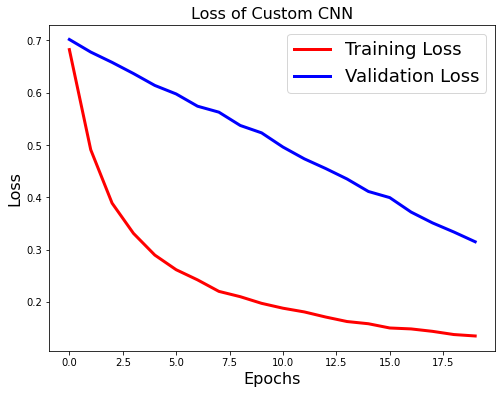

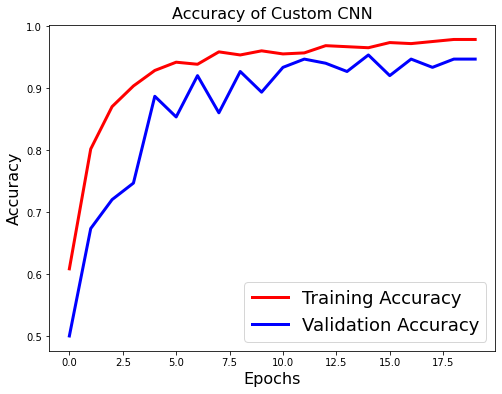

In [74]:
test_custom_CNN(20)

####  3.2.13.2 VGG Tests

Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0  

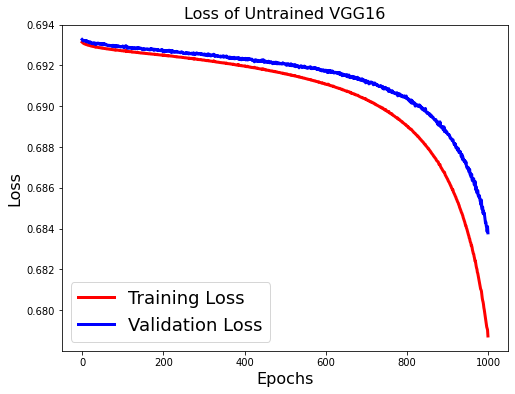

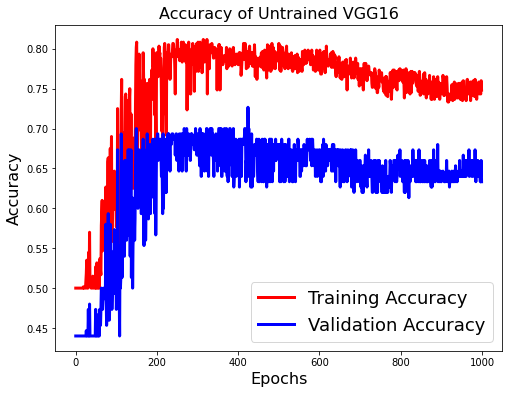

In [77]:
test_untrained_VGG(1000, model_name="VGG16")

58892288/58889256 [==============================] - 1s 0us/step
Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
___________________________________________________________

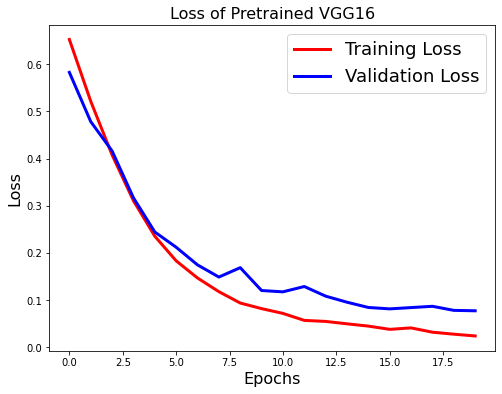

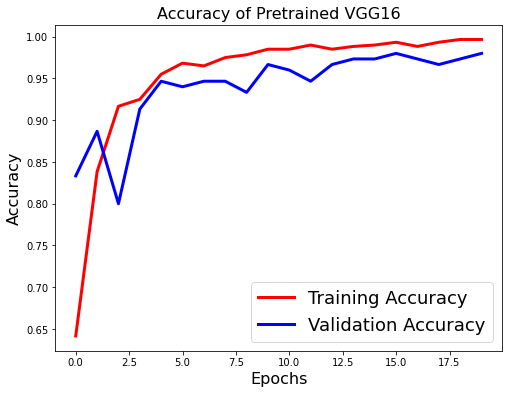

In [78]:
test_pretrained_VGG(20, model_name="VGG16")

Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0  

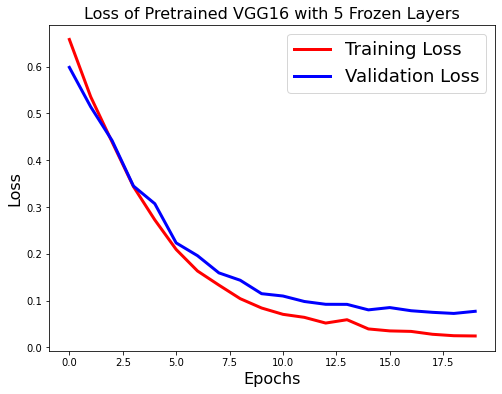

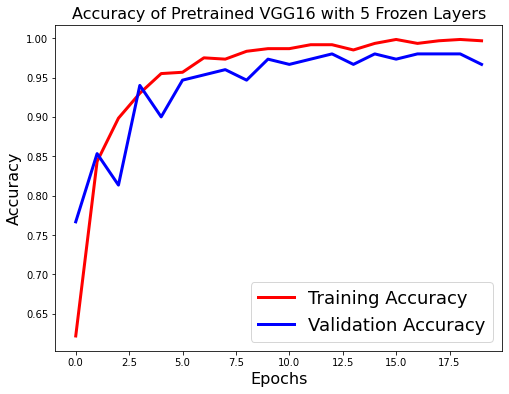

In [79]:
test_pretrained_layers_freezing_VGG(20, model_name="VGG16")

Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0  

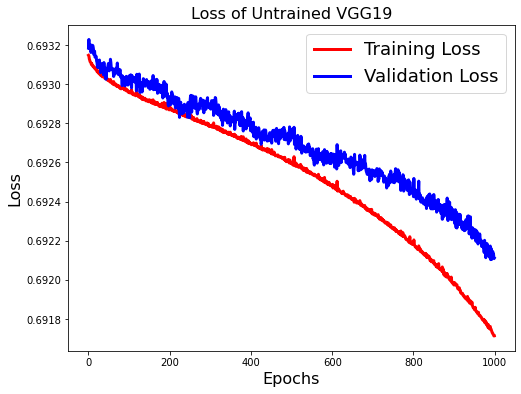

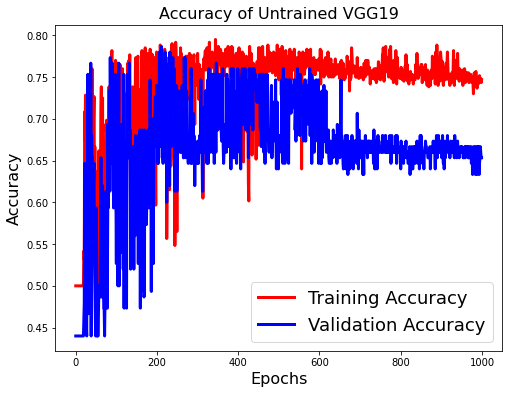

In [80]:
test_untrained_VGG(1000, model_name="VGG19")

Model: "model_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0  

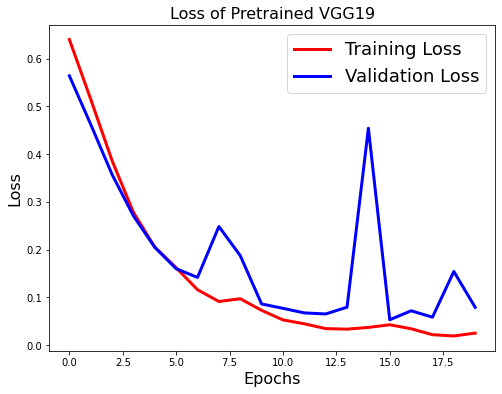

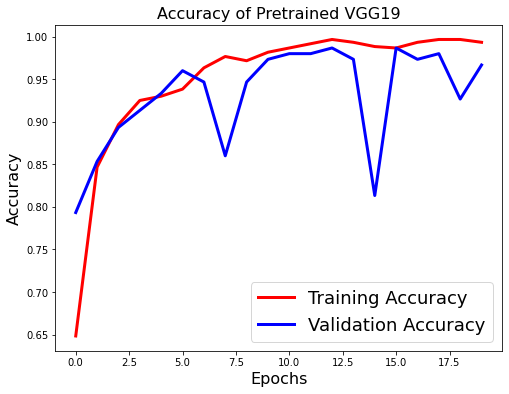

In [81]:
test_pretrained_VGG(20, model_name="VGG19")

Model: "model_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0  

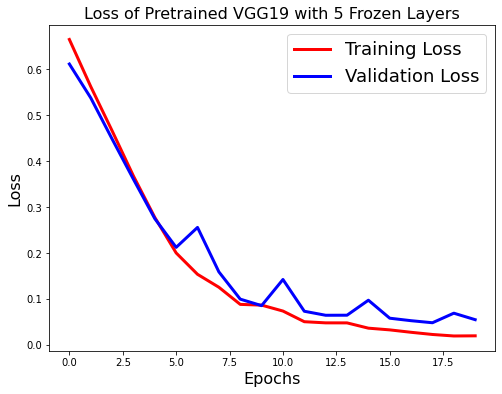

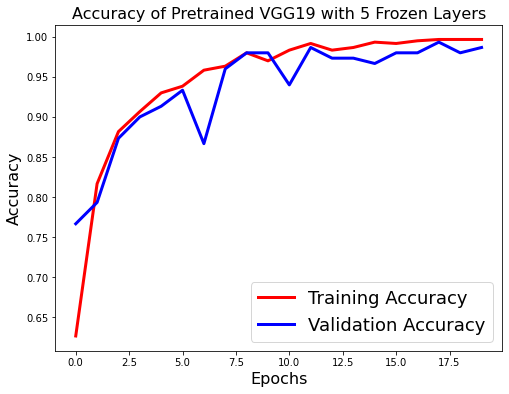

In [82]:
test_pretrained_layers_freezing_VGG(20, model_name="VGG19", n_frozen_layers=5)

Model: "model_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_57 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0  

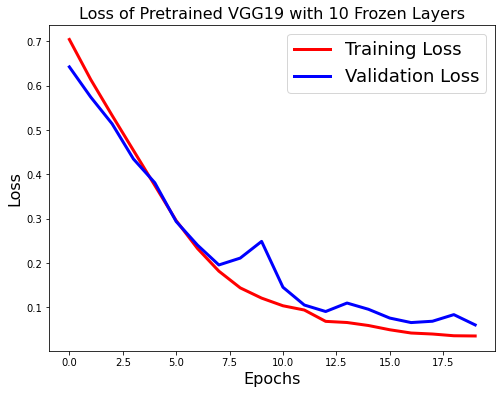

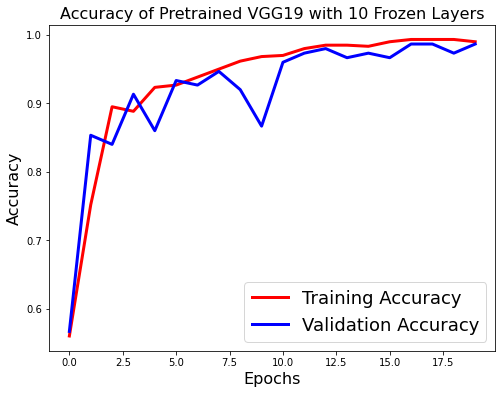

In [178]:
test_pretrained_layers_freezing_VGG(20, model_name="VGG19", n_frozen_layers=10)

Model: "model_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_58 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0  

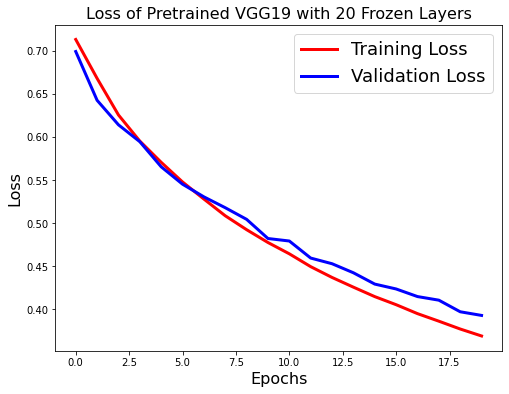

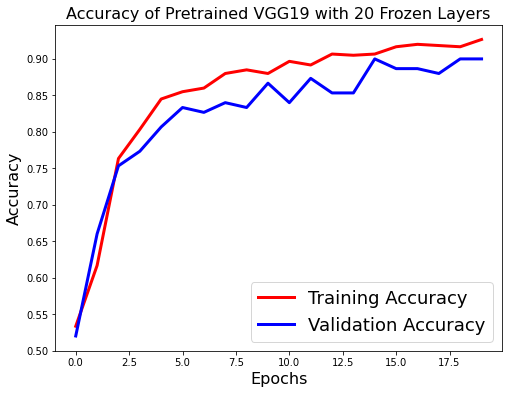

In [179]:
test_pretrained_layers_freezing_VGG(20, model_name="VGG19", n_frozen_layers=20)

Model: "model_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_59 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0  

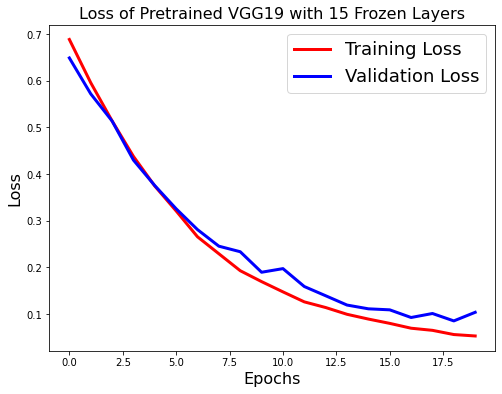

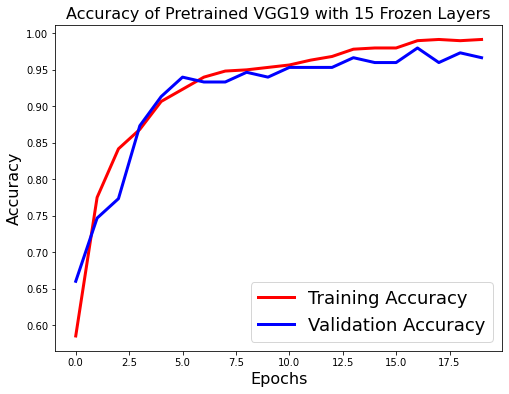

In [180]:
test_pretrained_layers_freezing_VGG(20, model_name="VGG19", n_frozen_layers=15)

Model: "model_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_60 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0  

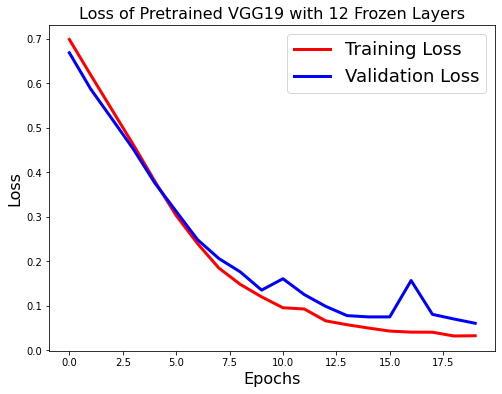

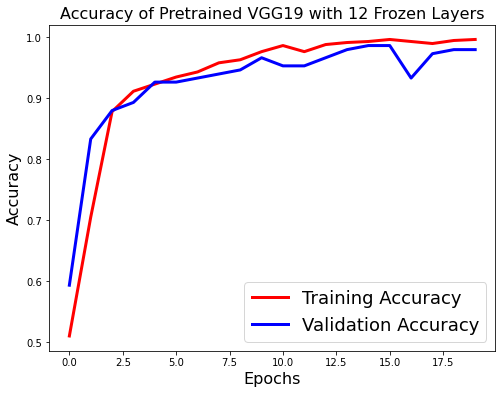

In [181]:
test_pretrained_layers_freezing_VGG(20, model_name="VGG19", n_frozen_layers=12)

####  3.2.13.2 ResNet Tests

Model: "model_33"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_34[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

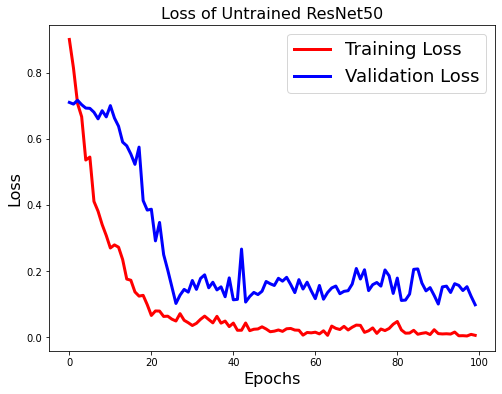

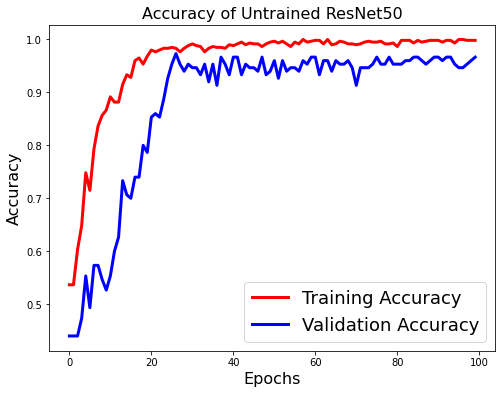

In [83]:
test_untrained_ResNet(100, model_name="ResNet50")

Model: "model_35"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_36 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_36[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

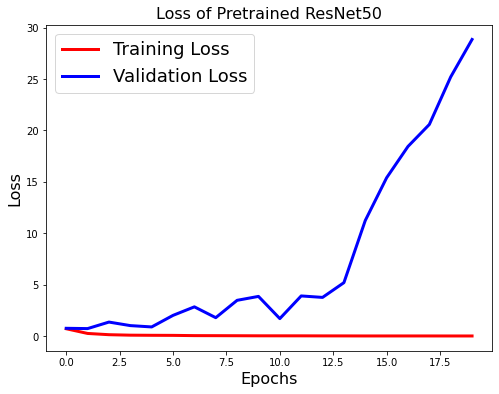

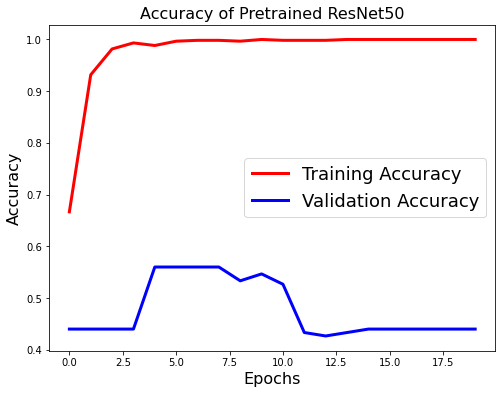

In [85]:
test_pretrained_ResNet(20, model_name="ResNet50")

Model: "model_36"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_37[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

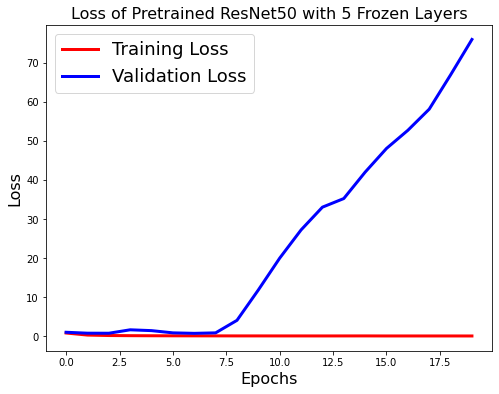

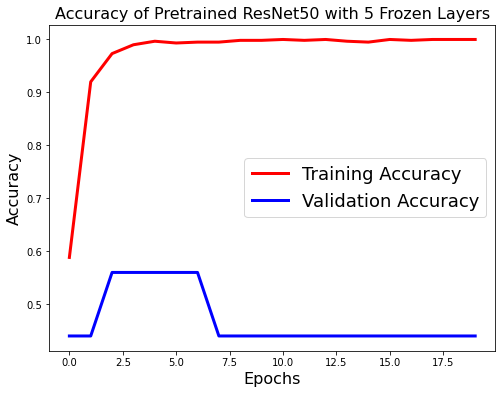

In [86]:
test_pretrained_layers_freezing_ResNet(20, model_name="ResNet50")

Model: "model_37"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_38 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_38[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 34, 34, 64)   0           conv1_conv[0][0]                 
___________________________________________________________________________________________

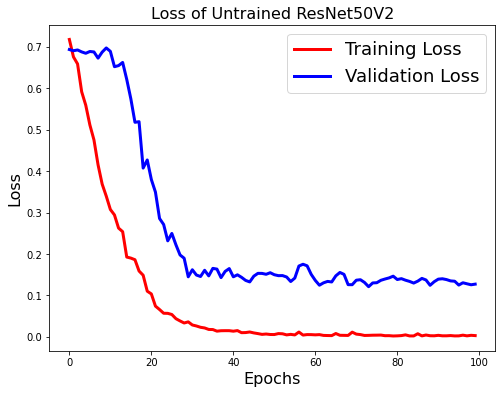

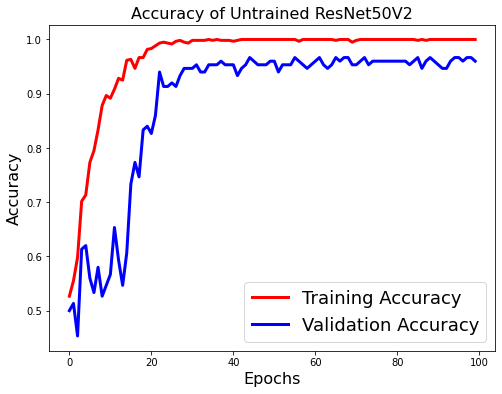

In [87]:
test_untrained_ResNet(100, model_name="ResNet50V2")

94674944/94668760 [==============================] - 1s 0us/step
Model: "model_38"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_39 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_39[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 34, 34, 64)   0           conv1_conv[0][0]                 
__________________________

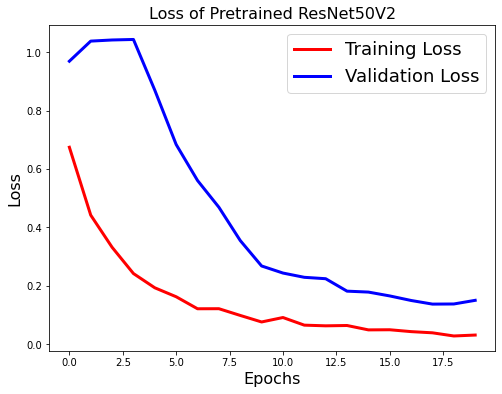

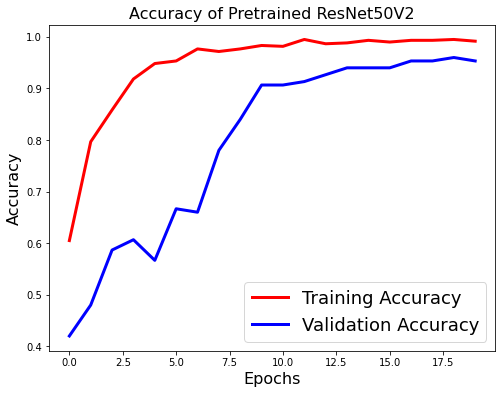

In [88]:
test_pretrained_ResNet(20, model_name="ResNet50V2")

Model: "model_39"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_40 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_40[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 34, 34, 64)   0           conv1_conv[0][0]                 
___________________________________________________________________________________________

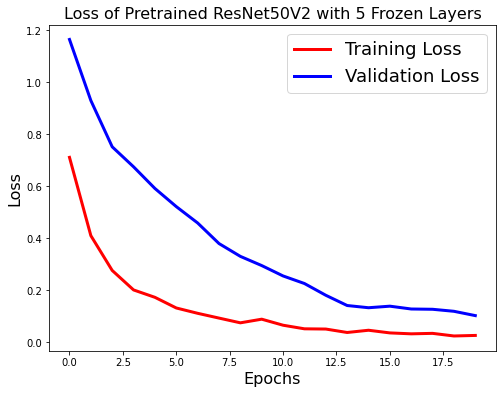

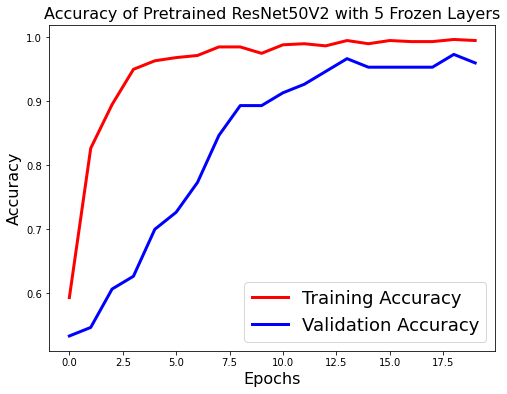

In [89]:
test_pretrained_layers_freezing_ResNet(20, model_name="ResNet50V2")

Model: "model_40"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_41[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

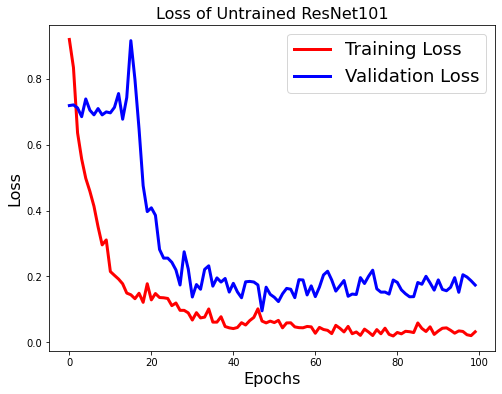

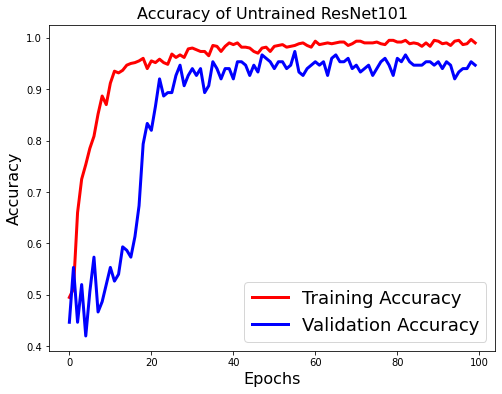

In [90]:
test_untrained_ResNet(100, model_name="ResNet101")

171450368/171446536 [==============================] - 2s 0us/step
Model: "model_41"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_42 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_42[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
________________________

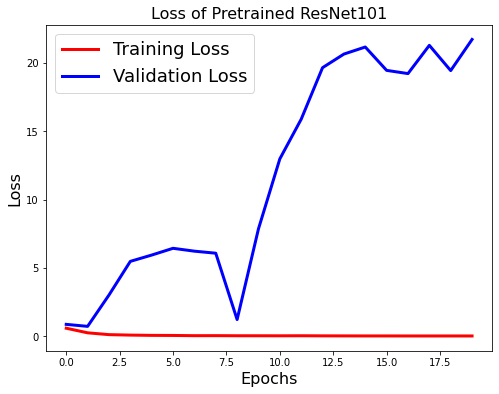

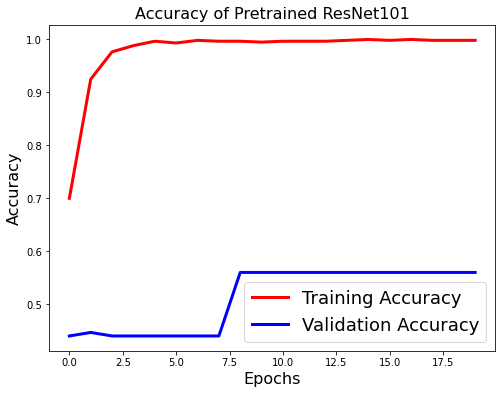

In [91]:
test_pretrained_ResNet(20, model_name="ResNet101")

Model: "model_42"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_43 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_43[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

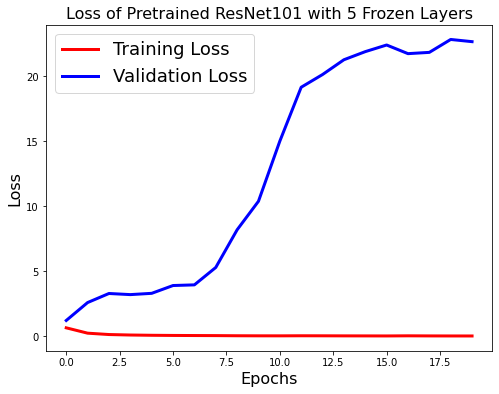

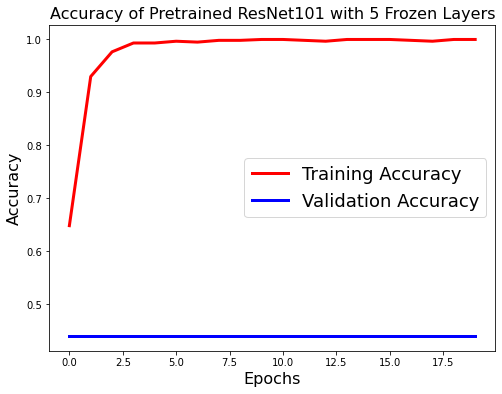

In [92]:
test_pretrained_layers_freezing_ResNet(20, model_name="ResNet101")

Model: "model_43"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_44 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_44[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 34, 34, 64)   0           conv1_conv[0][0]                 
___________________________________________________________________________________________

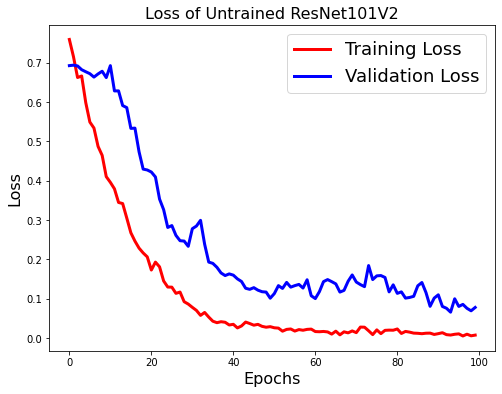

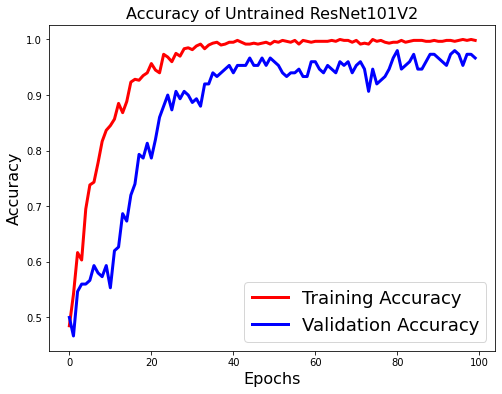

In [93]:
test_untrained_ResNet(100, model_name="ResNet101V2")

Model: "model_44"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_45 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_45[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 34, 34, 64)   0           conv1_conv[0][0]                 
___________________________________________________________________________________________

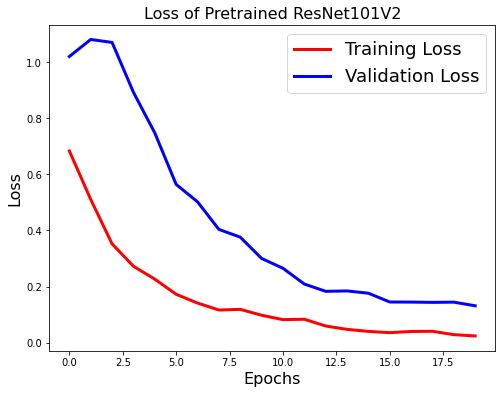

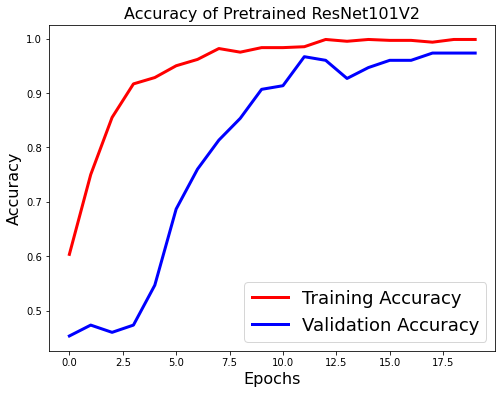

In [94]:
test_pretrained_ResNet(20, model_name="ResNet101V2")

Model: "model_45"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_46 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_46[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 34, 34, 64)   0           conv1_conv[0][0]                 
___________________________________________________________________________________________

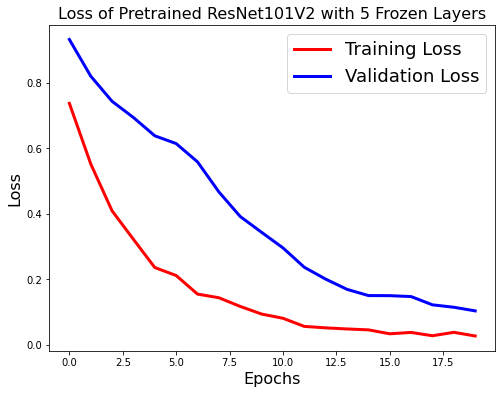

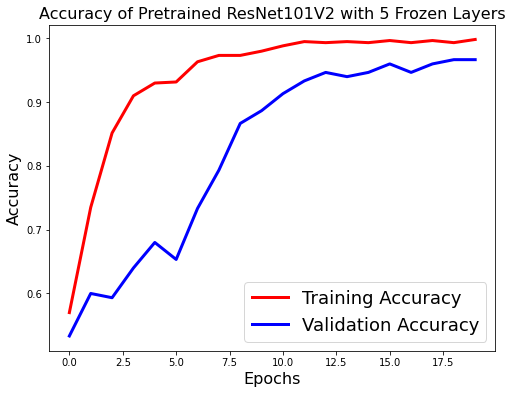

In [95]:
test_pretrained_layers_freezing_ResNet(20, model_name="ResNet101V2")

####  3.2.13.2 Inception Tests

Model: "model_50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_51 (InputLayer)           [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_812 (Conv2D)             (None, 37, 37, 32)   864         input_51[0][0]                   
__________________________________________________________________________________________________
batch_normalization_812 (BatchN (None, 37, 37, 32)   96          conv2d_812[0][0]                 
__________________________________________________________________________________________________
activation_816 (Activation)     (None, 37, 37, 32)   0           batch_normalization_812[0][0]    
___________________________________________________________________________________________

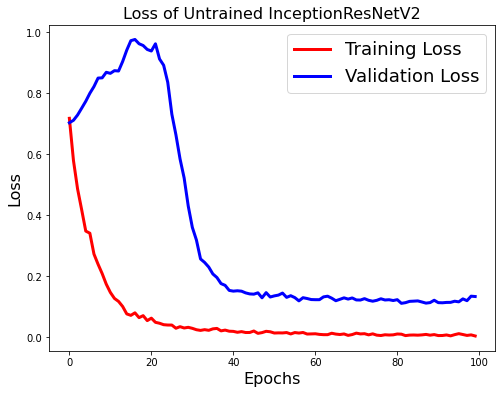

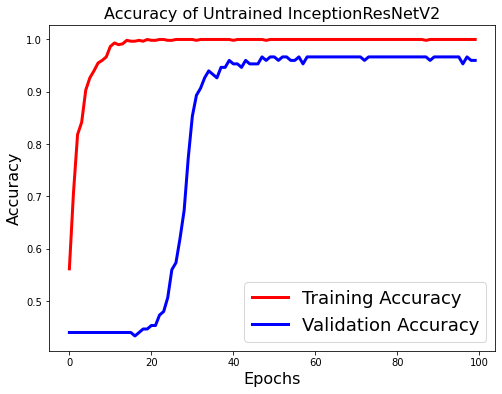

In [171]:
test_untrained_Inception(100, model_name="InceptionResNetV2")

219062272/219055592 [==============================] - 2s 0us/step
Model: "model_51"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_52 (InputLayer)           [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_1015 (Conv2D)            (None, 37, 37, 32)   864         input_52[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1015 (Batch (None, 37, 37, 32)   96          conv2d_1015[0][0]                
__________________________________________________________________________________________________
activation_1019 (Activation)    (None, 37, 37, 32)   0           batch_normalization_1015[0][0]   
________________________

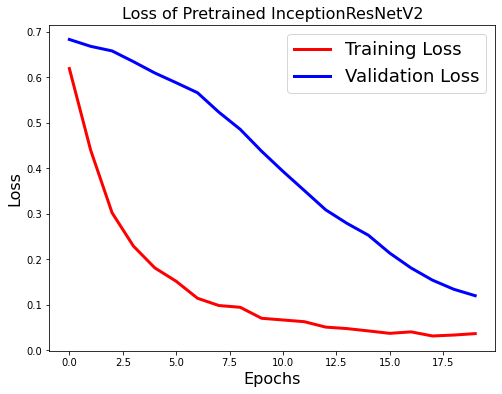

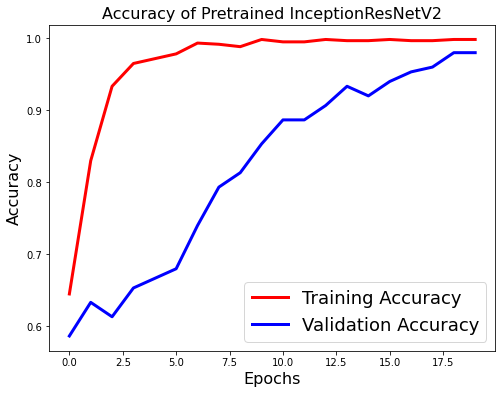

In [172]:
test_pretrained_Inception(20, model_name="InceptionResNetV2")

Model: "model_52"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_53 (InputLayer)           [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_1218 (Conv2D)            (None, 37, 37, 32)   864         input_53[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1218 (Batch (None, 37, 37, 32)   96          conv2d_1218[0][0]                
__________________________________________________________________________________________________
activation_1222 (Activation)    (None, 37, 37, 32)   0           batch_normalization_1218[0][0]   
___________________________________________________________________________________________

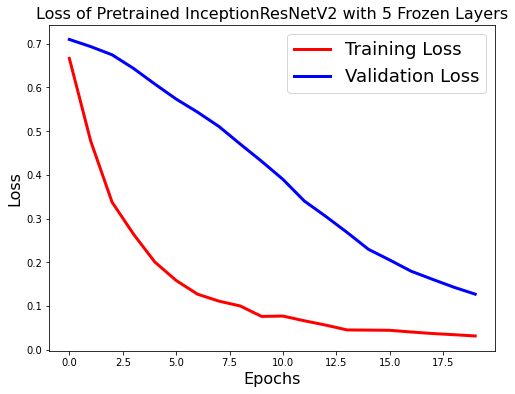

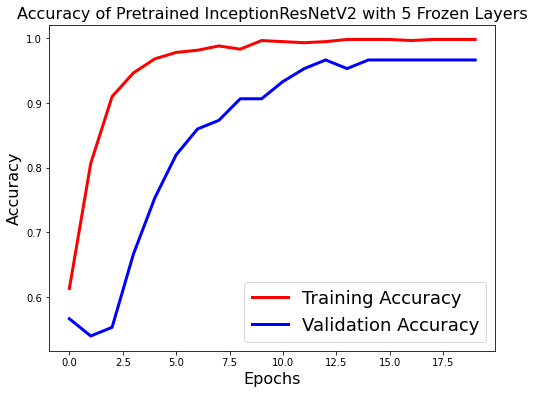

In [173]:
test_pretrained_layers_freezing_Inception(20, model_name="InceptionResNetV2")

Model: "model_53"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_54 (InputLayer)           [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_1421 (Conv2D)            (None, 37, 37, 32)   864         input_54[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1421 (Batch (None, 37, 37, 32)   96          conv2d_1421[0][0]                
__________________________________________________________________________________________________
activation_1425 (Activation)    (None, 37, 37, 32)   0           batch_normalization_1421[0][0]   
___________________________________________________________________________________________

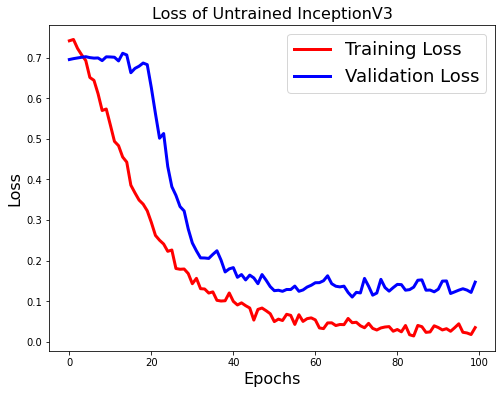

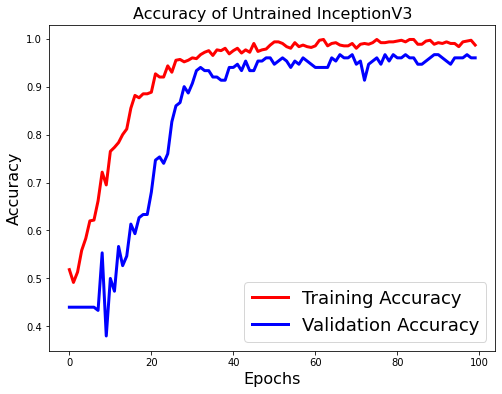

In [174]:
test_untrained_Inception(100, model_name="InceptionV3")

87916544/87910968 [==============================] - 0s 0us/step
Model: "model_54"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_55 (InputLayer)           [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_1515 (Conv2D)            (None, 37, 37, 32)   864         input_55[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1515 (Batch (None, 37, 37, 32)   96          conv2d_1515[0][0]                
__________________________________________________________________________________________________
activation_1519 (Activation)    (None, 37, 37, 32)   0           batch_normalization_1515[0][0]   
__________________________

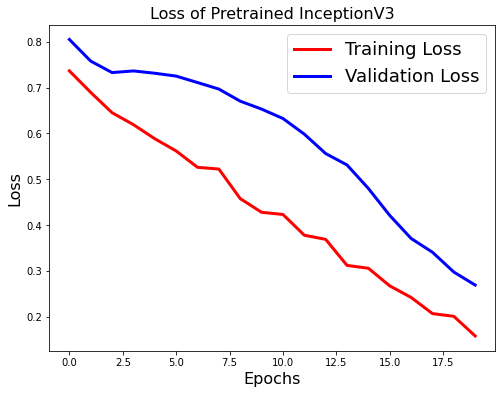

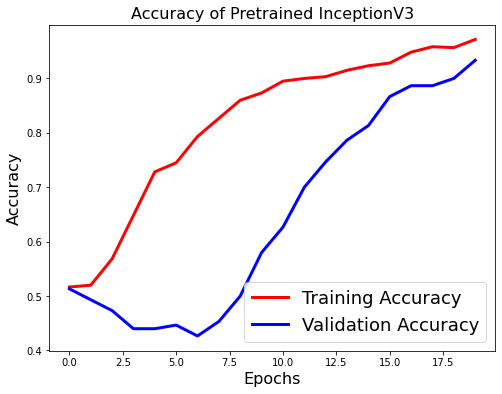

In [175]:
test_pretrained_Inception(20, model_name="InceptionV3")

Model: "model_55"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_56 (InputLayer)           [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_1609 (Conv2D)            (None, 37, 37, 32)   864         input_56[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1609 (Batch (None, 37, 37, 32)   96          conv2d_1609[0][0]                
__________________________________________________________________________________________________
activation_1613 (Activation)    (None, 37, 37, 32)   0           batch_normalization_1609[0][0]   
___________________________________________________________________________________________

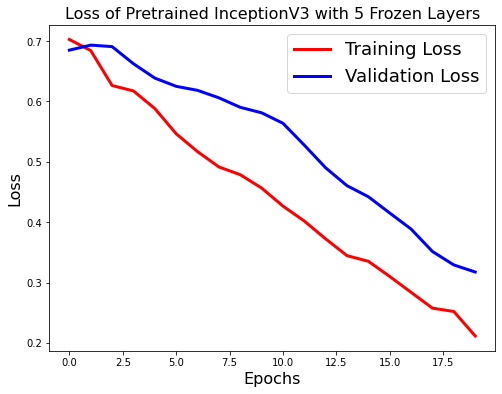

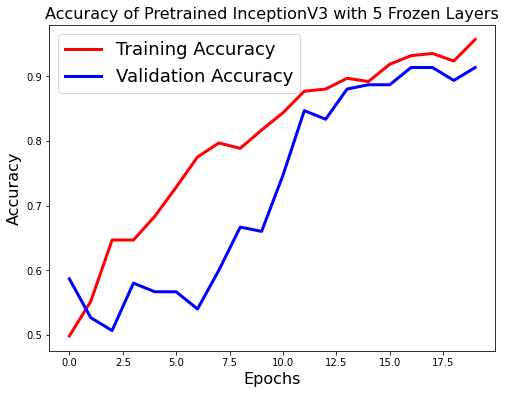

In [176]:
test_pretrained_layers_freezing_Inception(20, model_name="InceptionV3")

###  3.2.14 Testing different Optimizers

####SGD

Model: "model_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_69 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0  

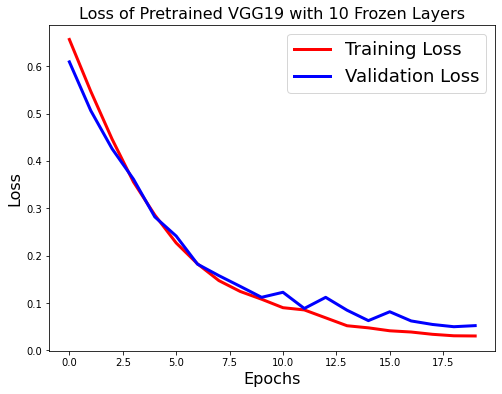

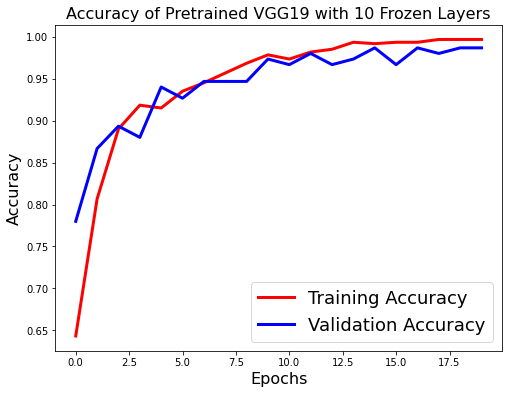

In [194]:
test_pretrained_layers_freezing_VGG(20, model_name="VGG19", n_frozen_layers=10)

####RMSprop

Model: "model_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_70 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0  

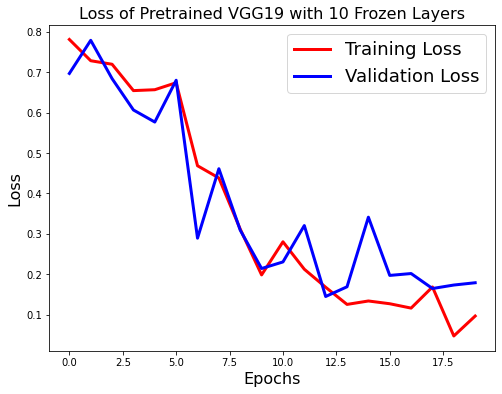

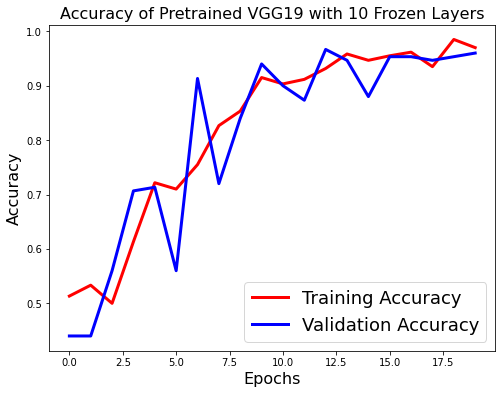

In [196]:
test_pretrained_layers_freezing_VGG(20, model_name="VGG19", n_frozen_layers=10)

####Adam

Model: "model_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_71 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0  

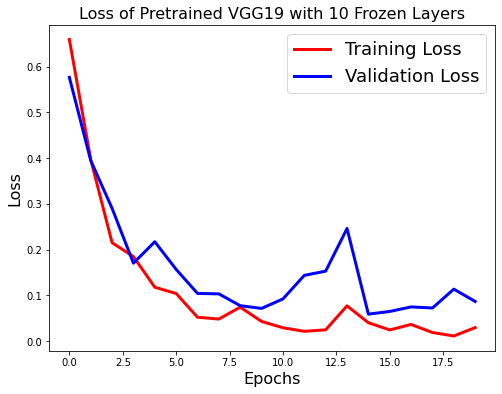

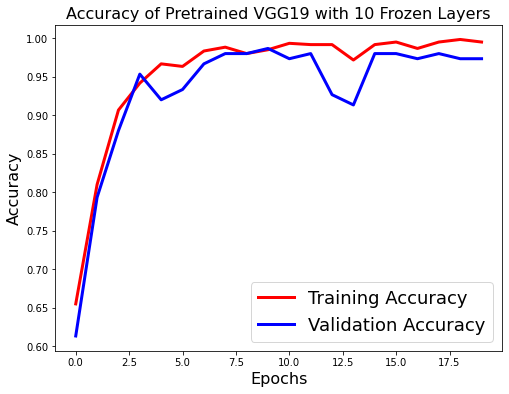

In [198]:
test_pretrained_layers_freezing_VGG(20, model_name="VGG19", n_frozen_layers=10)

####Adadelta

Model: "model_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_80 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0  

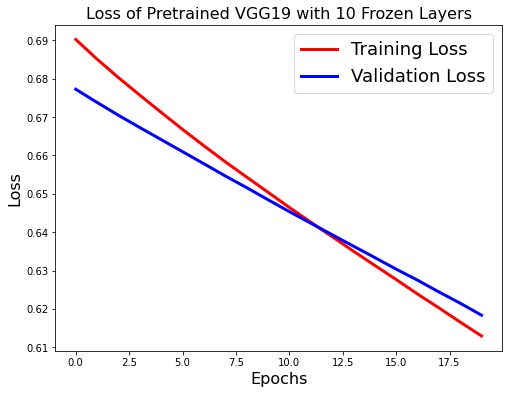

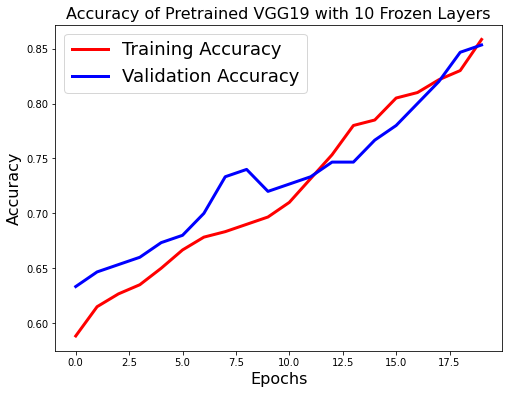

In [217]:
test_pretrained_layers_freezing_VGG(20, model_name="VGG19", n_frozen_layers=10)

####Adagrad

Model: "model_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_72 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0  

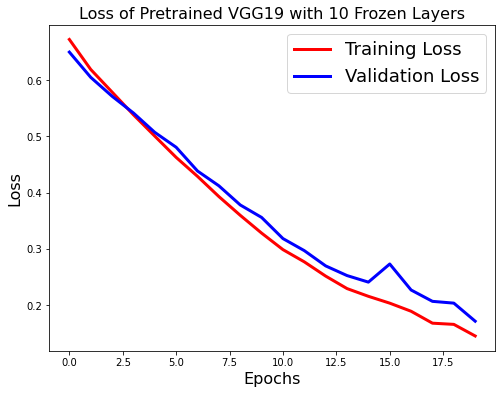

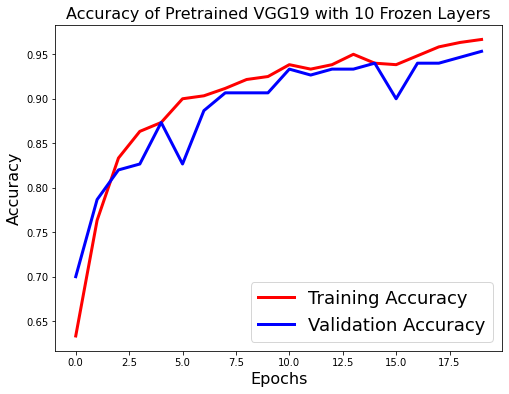

In [200]:
test_pretrained_layers_freezing_VGG(20, model_name="VGG19", n_frozen_layers=10)

####Adamax

Model: "model_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_73 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0  

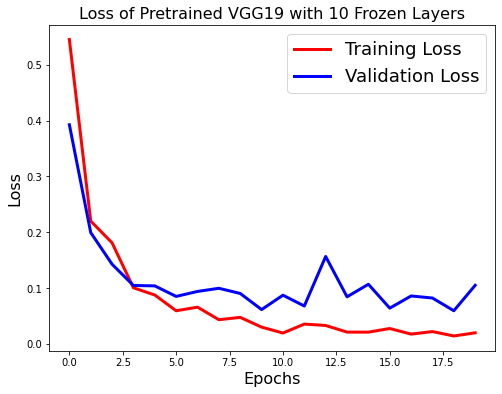

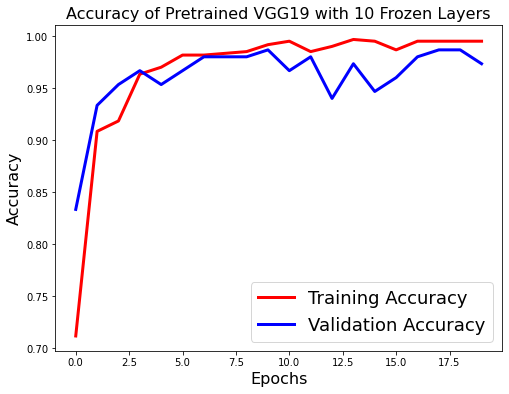

In [202]:
test_pretrained_layers_freezing_VGG(20, model_name="VGG19", n_frozen_layers=10)

####Nadam

Model: "model_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_74 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0  

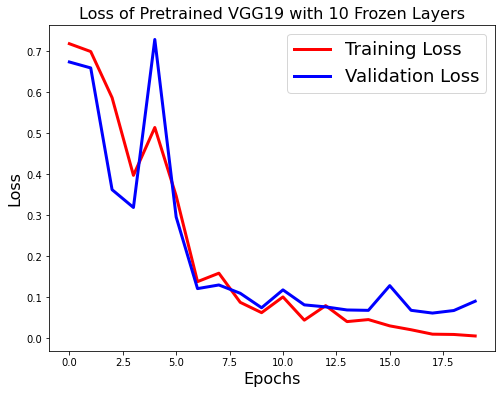

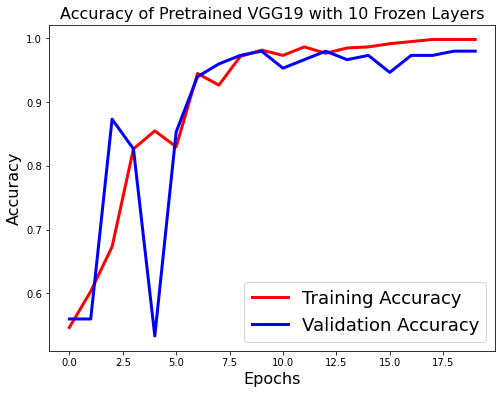

In [204]:
test_pretrained_layers_freezing_VGG(20, model_name="VGG19", n_frozen_layers=10)

####Ftrl

Model: "model_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_76 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0  

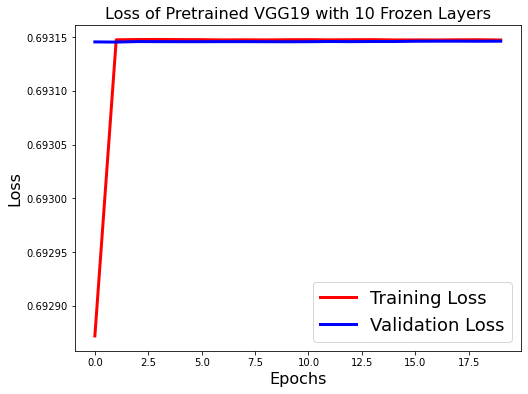

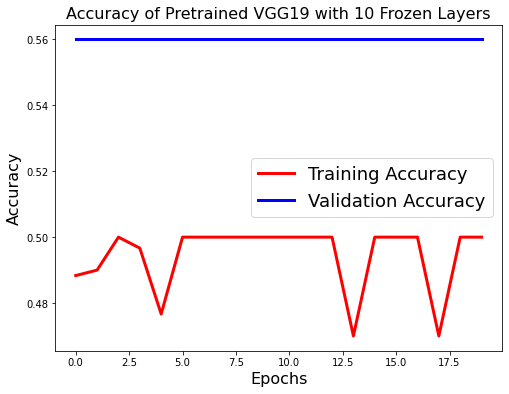

In [207]:
test_pretrained_layers_freezing_VGG(20, model_name="VGG19", n_frozen_layers=10)

###  3.2.15 Testing different Loss Functions
Since the problem is binary classification, I think the only loss functions suitable to test are the "binary_crossentropy", "hinge", and "squared_hinge" loss functions.

####Binary Cross-entropy

Model: "model_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_77 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0  

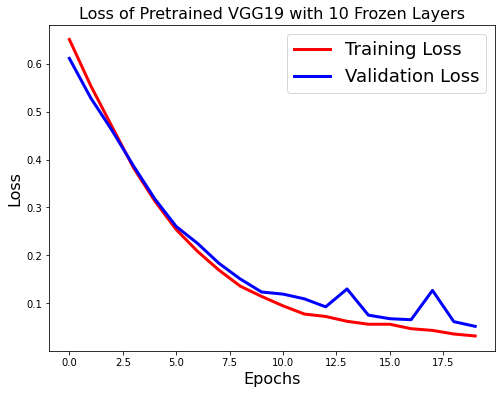

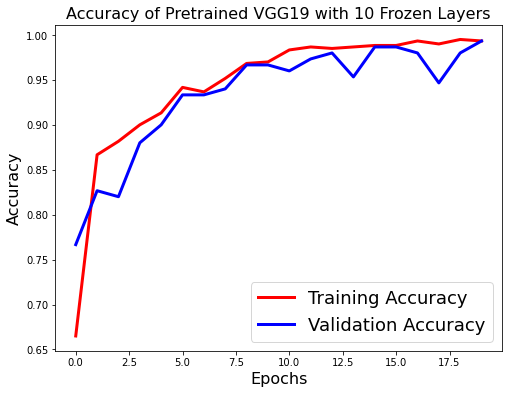

In [210]:
test_pretrained_layers_freezing_VGG(20, model_name="VGG19", n_frozen_layers=10)

####Hinge

Model: "model_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_78 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0  

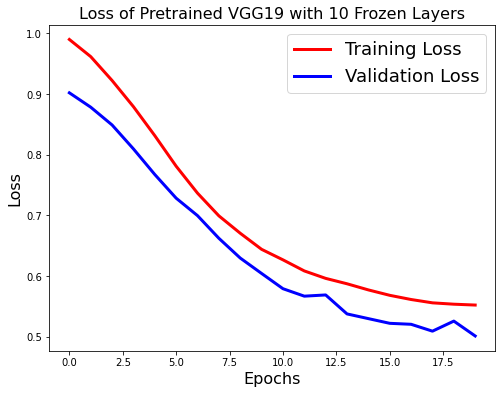

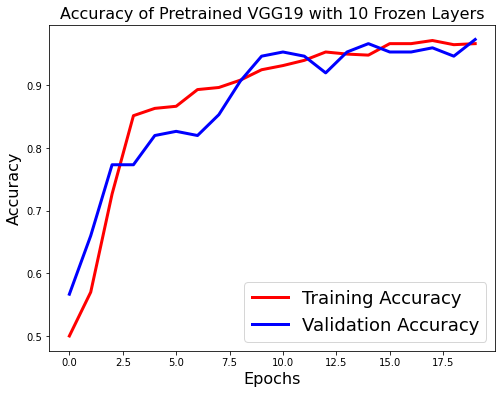

In [212]:
test_pretrained_layers_freezing_VGG(20, model_name="VGG19", n_frozen_layers=10)

####Squared Hinge

Model: "model_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_79 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0  

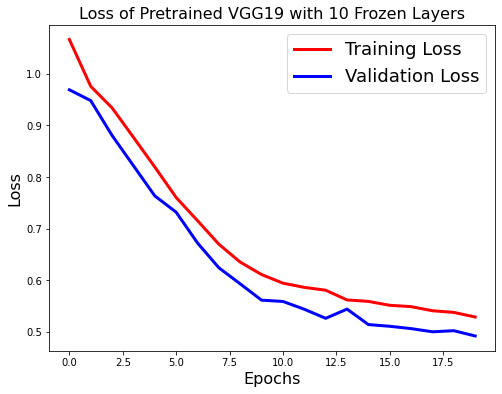

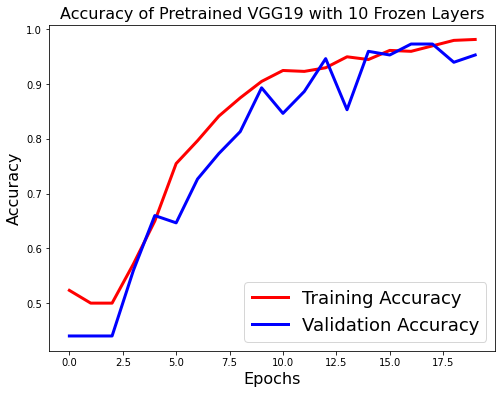

In [215]:
test_pretrained_layers_freezing_VGG(20, model_name="VGG19", n_frozen_layers=10)

## 3.3 Conclusion

That's it! Congratulations on training CNN use cases models.

Make sure you deliver all the requirements for the submission.